# Background



The Heston model is a means of describing the evolution of asset prices over time.

The Heston model assumes that the volatility of volatility is a constant.

The following Stochastic Differential Equations govern the Heston model:

$$dS_t= r S_tdt + \sqrt{v_t}S_tdW_t^S$$

$$dv_t=\kappa (\theta-v_t)dt + \xi\sqrt{v_t}dW_t^v$$

The first SDE involves following variables:
- $S_t$: the asset price as a function of time
- $r$: the risk-free rate.
- $W_t^S$: Brownian motion for the asset
- $v_t$: the volatility as a function of time.
The second SDE involves the following variables:
- $\kappa$: Mean reversion rate
- $\theta$: Long-term average variance
- $\xi$: Volatility of volatility
- $v_0$: Initial variance (may be distinct from $\theta$)
- $W_t^v$: Brownian motion for the volatility.
- $\rho$: The correlation between the asset price and volatility; defined as $corr(W_t^S, W_t^v)$

Of the variables above, the following are parameters:
- $S_0$: Initial asset price
- $v_0$
- $r$
- $\theta$
- $\kappa$
- $\xi$ 
- $\rho$

Our goal is to estimate $S_t$ to a high level of accuracy. This is necessary to estimate the value of a call option.

Specifically, the call option value is defined as:
$$\max(S_T-K, 0)$$
Where $T$ is the time to maturity and $K$ is the strike price. These are also user-inputtable parameters.

To find $S_t$, we must discretize the SDE's as follows:

### Step 1: Time grid
This part is simple:
- Let N be the number of steps to run. Then let $\Delta t$ = $\frac{T}{N}$
- Let $t_k = k\Delta t$, where N is the number of steps to run.

### Step 2: Correlated Brownian increments
The following setup creates standard normal variables with covariance $\rho$:
- $Z_S \sim \mathcal{N}(0,1)$
- $Z_v = \rho Z_S + \lambda\sqrt{1-\rho^2}, \lambda\sim \mathcal{N}(0,1)$ independent of $Z_S$

### Step 3: Discretize volatility $v_t$ using Milstein scheme
The following equation uses the Milstein scheme to discretize $v_t$:
$$v_{t+\Delta t}=v_t+\kappa(\theta-\max(v_t, 0))\Delta t+Z_v\xi\sqrt{\max(v_t, 0)\Delta t}+\frac{\xi^2}{4}[(Z_v\sqrt{\Delta t})^2 - \Delta t]$$

### Step 4: Discretize the asset price $S_t$
The following equation can discretise S:
$$S_{t+\Delta t}=S_t \exp \left( \left( r-\frac{v_t}{2} \right)\Delta t + Z_S\sqrt{v_t\Delta t} \right)$$

# Code

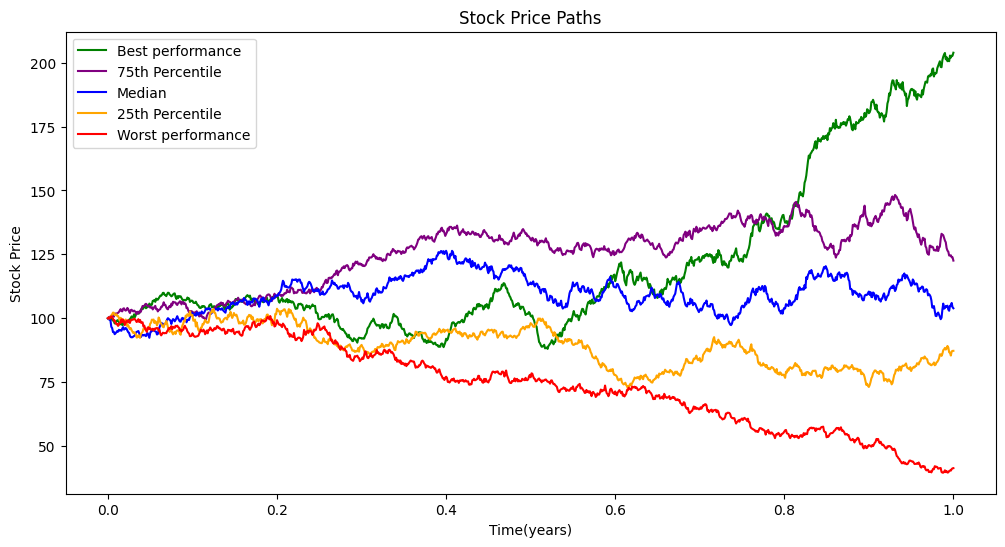

Option Price: 12.93
Black-Scholes Price: 10.45


In [36]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Simulation of volatility and stock price paths
def simulate_paths(S0, v0, r, theta, kappa, xi, rho, T, N):

    # Computed constants
    dt = T / N
    S = np.zeros(N + 1)
    v = np.zeros(N + 1)
    S[0] = S0
    v[0] = v0

    for i in range(1, N + 1):
        # Simulate the normal variables
        Z_S = np.random.normal()
        Z_v = rho * Z_S + np.sqrt(1 - rho**2) * np.random.normal()
        

        # Update the volatility using the Milstein scheme
        v[i] = v[i - 1] + kappa * (theta - max(v[i-1], 0)) * dt + Z_v * xi * np.sqrt(max(v[i-1], 0)*dt) + (xi*xi/4) * ((Z_v*Z_v - 1)*dt)
        S[i] = S[i - 1] * np.exp((r-v[i-1]/2)*dt + Z_S*np.sqrt(max(v[i-1], 0)*dt))
    return S

# Monte carlo simulation of the Heston model
def monte_carlo_heston(S0, v0, r, theta, kappa, xi, rho, T, N, M, K):
    all_S = np.zeros((M, N + 1))
    for i in range(M):
        all_S[i] = simulate_paths(S0, v0, r, theta, kappa, xi, rho, T, N)
    # Sort all_S in order of the final stock price S_T
    all_S = all_S[np.argsort(all_S[:, -1])]
    S_min = all_S[0, :]  # Minimum final stock price
    S_max = all_S[M - 1, :] # Maximum final stock price
    # Calculate 25th percentile, median, and 75th percentile of final stock prices
    S_median = all_S[M // 2, :]  # Median final stock price   
    S_25 = all_S[M // 4, :]  # 25th percentile final stock price
    S_75 = all_S[3 * M // 4, :]  # 75th percentile final stock price


    payoffs = np.maximum(all_S[:, -1] - K, 0)
    mean_payoff = np.mean(payoffs)
    option_price = np.exp(-r * T) * mean_payoff  # Discounted expected payoff

    return option_price, S_min, S_25, S_median, S_75, S_max


def plot_paths(T, N, S_min, S_25, S_median, S_75, S_max):
    # Compute time grid
    time_grid = np.linspace(0, T, N + 1)
    # Plot the paths: max = green, min = red, median = blue
    plt.figure(figsize=(12, 6))
    plt.plot(time_grid, S_max, color='green', label='Best performance')
    plt.plot(time_grid, S_75, color='purple', label='75th Percentile')

    plt.plot(time_grid, S_median, color='blue', label='Median')
    plt.plot(time_grid, S_25, color='orange', label='25th Percentile')

    plt.plot(time_grid, S_min, color='red', label='Worst performance')


    plt.title('Stock Price Paths')
    plt.xlabel('Time(years)')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

def black_scholes_call(S0, K, r, T, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S0 * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)
    return call_price

def simulate(        
        # Parameters
        S0 = 100, # Initial stock price
        v0 = 0.04, # Initial variance
        r = 0.05, # Risk-free interest rate
        theta = 0.1, # Long-term volatility level
        kappa = 1.0, # Speed of mean reversion
        xi = 0.2, # Volatility of variance
        rho = -0.5, # Correlation between stock and volatility
        T = 1.0, # Time to maturity in years
        K = 100, # Strike price
        N = 1000, # Number of points
        M = 1000 # Number of simulations
):
    option_price, S_min, S_25, S_median, S_75, S_max = monte_carlo_heston(S0, v0, r, theta, kappa, xi, rho, T, N, M, K)
    plot_paths(T, N, S_min, S_25, S_median, S_75, S_max)
    print(f"Option Price: {option_price:.2f}")
    # Compute the option price from the black-scholes formula for comparison
    sigma = np.sqrt(v0)  # Initial volatility
    bs_price = black_scholes_call(S0, K, r, T, sigma)
    print(f"Black-Scholes Price: {bs_price:.2f}")

# Run the simulation
simulate()
